# Jupyter version of the code to calculate monthly ASC speed on the XY grid

In [1]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
import numpy as np
import os
from dask.distributed import Client
# Optional modules
import xgcm
# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37845,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:41485,Total threads: 4
Dashboard: /proxy/36959/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:42601,


In [3]:
import cosima_cookbook as cc
session = cc.database.create_session()

In [44]:
expt = '01deg_jra55v140_iaf_cycle3'	
lat_slice = slice(-80, -57.6)

In [45]:
start_time='1958-01-01'
end_time='1958-01-31'

In [46]:
		uhrho = cc.querying.getvar(expt, 'uhrho_et', session,start_time=start_time, end_time=end_time,frequency='1 daily')
		uhrho = uhrho.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
		vhrho = cc.querying.getvar(expt, 'vhrho_nt', session,start_time=start_time, end_time=end_time,frequency='1 daily')
		vhrho = vhrho.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

To convert from transport to u,v , the steps should be:

[a] Divide the transports by dzt and by rho.

[b] Transpose transports from the Tgrid to the stepwise grid (Cel faces)

In [47]:
		rho=1035
		ht = cc.querying.getvar(expt, 'dzt', session,start_time=start_time, end_time=end_time,frequency='1 monthly')
		ht=ht.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).isel(time=0,drop=True)

Notice that we used monthly dzt for these calculations (Not ideal, but it is the output we have)

In [48]:
		u=(uhrho/ht)/rho
		v=(vhrho/ht)/rho
		u.name='u'
		v.name='v'

In [50]:
		cutout_latind = int(np.size(ht.yt_ocean))
		cutout_latind

510

In [78]:
	# Import bathymetry
	hu = cc.querying.getvar(expt, 'hu', session, n=1)
	
	# Import grid cell length
	dxu = cc.querying.getvar(expt, 'dxu', session, n=1)
	dyu = cc.querying.getvar(expt, 'dyu', session, n=1)
	
	##THis part below doesnt need to be run for IAF experiments, BUT SHOULD BE UNCOMMENTED FOR RYF EXPERIMENTS  
	## Change coordinate name
	dxu.coords['xu_ocean'] = hu['xu_ocean'].values                            ####################################
	dxu.coords['yu_ocean'] = hu['yu_ocean'].values                            ####################################
	dyu.coords['xu_ocean'] = hu['xu_ocean'].values                            ####################################
	dyu.coords['yu_ocean'] = hu['yu_ocean'].values                            ####################################

	
	# Select latitude range
	hu = hu.sel(yu_ocean=lat_slice)
	hu = hu.load()
	dxu = dxu.sel(yu_ocean=lat_slice)
	dxu = dxu.load()
	dyu = dyu.sel(yu_ocean=lat_slice)
	dyu = dyu.load()
	
	# Load model grid information
	path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
	grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

	ds = xr.merge([hu, grid])
	ds.coords['xt_ocean'].attrs.update(axis='X')
	ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
	ds.coords['yt_ocean'].attrs.update(axis='Y')
	ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
	
	grid = xgcm.Grid(ds, periodic=['X'])
	
	# Take gradient and move to u grid
	# Simple gradient over one grid cell. 
	# In latitudinal direction, we need to specify what happens at the boundary.
	dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
	dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')
	
	# Same as: (other option)
	#dhu_dx = grid.interp(grid.diff(ds.hu, 'X'), 'X') / ds.dxu
	#dhu_dy = grid.interp(grid.diff(ds.hu, 'Y', boundary='extend'), 'Y', boundary='extend') / ds.dyu
	
	# Select latitude slice
	dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
	dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)
	
	# Calculate the magnitude of the topographic slope
	slope = (dhu_dx**2 + dhu_dy**2)**0.5 #before it was : xu.sqrt(dhu_dx**2 + dhu_dy**2)
	
	    
	    
	    
	#This code calcualtes U_along speed on X,Y grid.  for reference   
	    
	               
	#
	#   Legend:
	#   o = u,v, original location
	#   Ux,Vx = u,v interpolated into the x grid    
	#   Uy,Vy = u,v interpolated into the y grid    
	#   t = Tracer grid (t,n)  
	#
	#
	#
	#         Uy,Vy (-279.95,-81.09)
	#           ^
	#           | 
	#   -------(+)------o=(u,v)(-279.90,-81.09)
	#  |                |   
	#  |                |
	#  |                |
	#  |       (t)     (+)--> Ux,Vx (-279.90,-81.11)
	#  |                |
	#  |                |
	#  |                |
	#   ----------------    
	    
	    
	    
	    
	 
	###################################################################  
	#interpolating the slope to x,y grid    
	Slopedata=xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/slope1000m.nc') 
	x_s=slope.xu_ocean
	y_s=slope.yu_ocean
	
	# Load model grid information
	path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
	gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
	
	dsx = xr.merge([Slopedata.slope, gridx])
	dsx.coords['xt_ocean'].attrs.update(axis='X')
	dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
	dsx.coords['yt_ocean'].attrs.update(axis='Y')
	dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
	
	gridx = xgcm.Grid(dsx, periodic=['X'])
	
	
	#y
	gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
	dsy = xr.merge([Slopedata.slope, gridy])
	dsy.coords['xt_ocean'].attrs.update(axis='X')
	dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
	dsy.coords['yt_ocean'].attrs.update(axis='Y')
	dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
	
	gridy = xgcm.Grid(dsy, periodic=['X'])
	
	# Calculating the slope on the x and y grid
	slope_xg=gridx.interp(dsx.slope, 'Y').isel(yt_ocean=slice(0,cutout_latind))
	slope_yg=gridx.interp(dsx.slope, 'X').isel(yu_ocean=slice(0,cutout_latind))
	    
	
	###################################################################    
	#Interpolating the dhu into the x and y grids
	x_s=slope.xu_ocean
	y_s=slope.yu_ocean
	# Load model grid information
	path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
	gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
	
	dsx = xr.merge([Slopedata.dhu_dy,Slopedata.dhu_dx, gridx])
	dsx.coords['xt_ocean'].attrs.update(axis='X')
	dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
	dsx.coords['yt_ocean'].attrs.update(axis='Y')
	dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
	gridx = xgcm.Grid(dsx, periodic=['X'])
	
	
	#y
	gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
	dsy = xr.merge([Slopedata.dhu_dy,Slopedata.dhu_dx, gridy])
	dsy.coords['xt_ocean'].attrs.update(axis='X')
	dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
	dsy.coords['yt_ocean'].attrs.update(axis='Y')
	dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
	gridy = xgcm.Grid(dsy, periodic=['X'])
	
	# Calculating the slope on the x and y grid
	dhu_dy_xg=gridx.interp(dsx.dhu_dy, 'Y').isel(yt_ocean=slice(0,cutout_latind))
	dhu_dy_yg=gridx.interp(dsx.dhu_dy, 'X').isel(yu_ocean=slice(0,cutout_latind))
	dhu_dx_xg=gridx.interp(dsx.dhu_dx, 'Y').isel(yt_ocean=slice(0,cutout_latind))
	dhu_dx_yg=gridx.interp(dsx.dhu_dx, 'X').isel(yu_ocean=slice(0,cutout_latind))
	
	
	

In [52]:
	yearinit = 1958
	imonth = str(1)
	monthseries=['01','02','03','04','05','06','07','08','09','10','11','12']
	dayseries=['31','28','31','30','31','30','31','31','30','31','30','31'] 
	mi=0
	isobath_depth = 1000
#	print(test)  
# 	print('isobath depth is ' + str(isobath_depth) + ' m')


In [80]:
		####################Interpolating U to x,y grid!!
		gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
		gridx=gridx.isel(time=0,drop=True)                              ###########################################
		dsx = xr.merge([u, gridx])
		dsx.coords['xt_ocean'].attrs.update(axis='X')
		dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
		dsx.coords['yt_ocean'].attrs.update(axis='Y')
		dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
		dsx=dsx.sel(time=slice(start_time,end_time))
		
		gridx = xgcm.Grid(dsx, periodic=['X'])
		
		
		#y
		gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
		gridy=gridy.isel(time=0,drop=True)                               ###########################################
		dsy = xr.merge([u, gridy])
		dsy.coords['xt_ocean'].attrs.update(axis='X')
		dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
		dsy.coords['yt_ocean'].attrs.update(axis='Y')
		dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
		dsy=dsy.sel(time=slice(start_time,end_time)) 
		
		gridy = xgcm.Grid(dsy, periodic=['X'])


In [81]:
		u_xg=gridx.interp(dsx.u, 'X').isel(yt_ocean=slice(0,cutout_latind))
		u_yg=gridx.interp(dsy.u, 'Y').isel(yu_ocean=slice(0,cutout_latind))

		

In [82]:
		####################Interpolating V to x,y grid!!
		gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
		gridx=gridx.isel(time=0,drop=True)                              ###########################################
		dsx = xr.merge([v, gridx])
		dsx.coords['xt_ocean'].attrs.update(axis='X')
		dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
		dsx.coords['yt_ocean'].attrs.update(axis='Y')
		dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
		dsx=dsx.sel(time=slice(start_time,end_time))
		gridx = xgcm.Grid(dsx, periodic=['X'])
		
		
		#y
		gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
		gridy=gridy.isel(time=0,drop=True)                               ###########################################
		dsy = xr.merge([v, gridy])
		dsy.coords['xt_ocean'].attrs.update(axis='X')
		dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
		dsy.coords['yt_ocean'].attrs.update(axis='Y')
		dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
		dsy=dsy.sel(time=slice(start_time,end_time))
		gridy = xgcm.Grid(dsy, periodic=['X'])
		
		

In [83]:
		v_xg=gridx.interp(dsx.v, 'X').isel(yt_ocean=slice(0,cutout_latind))
		v_yg=gridx.interp(dsy.v, 'Y').isel(yu_ocean=slice(0,cutout_latind))

In [84]:
		############################ Along-slope velocity
		Uxg_along = u_xg*dhu_dy_xg/slope_xg - v_xg*dhu_dx_xg/slope_xg
		Uyg_along = u_yg*dhu_dy_yg/slope_yg - v_yg*dhu_dx_yg/slope_yg

In [85]:
		Vxg_cross = u_xg*dhu_dx_xg/slope_xg + v_xg*dhu_dy_xg/slope_xg        
		Vyg_cross = u_yg*dhu_dx_yg/slope_yg + v_yg*dhu_dy_yg/slope_yg

In [59]:
		# import edges of st_ocean and add lat/lon dimensions:
		st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, start_time=start_time, end_time=end_time, n=1)
		st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':hu.yu_ocean,'xu_ocean':hu.xu_ocean}, axis=[1,2])               ############################
		
		# adjust edges at bottom for partial thickness:
		st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
		thickness = st_edges_with_partial.diff(dim='st_edges_ocean')
		
		# change coordinate of thickness to st_ocean (needed for multipling with other variables):
		st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
		thickness['st_edges_ocean'] = st_ocean.values
		thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
		thickness = thickness
		


In [60]:
		########### Import Adeles 1km contour on X,Y grid                
		outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
		data = np.load(outfile)
		mask_y_transport = data['mask_y_transport']; 
		mask_y_transport=mask_y_transport[:cutout_latind,:]       ##############################
		mask_x_transport = data['mask_x_transport']; 
		mask_x_transport=mask_x_transport[:cutout_latind,:]		################################
		mask_y_transport_numbered = data['mask_y_transport_numbered']
		mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################
		mask_x_transport_numbered = data['mask_x_transport_numbered']
		mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################
		
		
		#cutting the matrices
		ylength= np.shape(mask_x_transport)[0]
		
		
		yt_ocean0 = cc.querying.getvar(expt,'yt_ocean',session,n=1)
		yt_ocean0 = yt_ocean0.isel(yt_ocean=slice(0,ylength))
		yu_ocean0 = cc.querying.getvar(expt,'yu_ocean',session,n=1)
		yu_ocean0 = yu_ocean0.isel(yu_ocean=slice(0,ylength))
		xt_ocean0 = cc.querying.getvar(expt,'xt_ocean',session,n=1)
		xu_ocean0 = cc.querying.getvar(expt,'xu_ocean',session,n=1)


In [61]:
		
		mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")
		mask_x_transport=mask_x_transport[:cutout_latind,:]       ##############################
		mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")
		mask_y_transport=mask_y_transport[:cutout_latind,:]		################################		
		mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")          ##################
		mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################		
		mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yu_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")          ##################
		mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################
		
		num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))                
		                
		
		
		
		
		############### Getting the lon,lat along contour in the X,Y contour
		lat_along_contour = np.zeros((num_points))
		lon_along_contour = np.zeros((num_points))
		# locations for zonal transport:
		x_indices_masked = mask_x_transport_numbered.stack().values
		x_indices = np.sort(x_indices_masked[x_indices_masked>0])
		for count in x_indices:
		    count = int(count)
		    jj = int(np.where(mask_x_transport_numbered==count)[0])
		    ii = int(np.where(mask_x_transport_numbered==count)[1])   
		    lon_along_contour[count-1] = xu_ocean0[ii].values
		    lat_along_contour[count-1] = mask_x_transport_numbered.y_ocean[jj].values
		    
		# locations for meridional transport:
		y_indices_masked = mask_y_transport_numbered.stack().values
		y_indices = np.sort(y_indices_masked[y_indices_masked>0])
		for count in y_indices:
		    count = int(count)
		    jj = np.where(mask_y_transport_numbered==count)[0]
		    ii = np.where(mask_y_transport_numbered==count)[1]
		    lon_along_contour[count-1] = mask_x_transport_numbered.x_ocean[ii].values           ##################          ##################          ##################          ##################          ##################          ##################
		    lat_along_contour[count-1] = yu_ocean0[jj].values
		
		
		
	

In [90]:
		%%time
		# Importing the Along-slope speed on x and y grid
		Uyg_along0=Uyg_along.load()
		Uxg_along0=Uxg_along.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:129: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:129: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:129: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 6min 50s, sys: 59.8 s, total: 7min 50s
Wall time: 8min 18s


In [91]:
		%%time
		Vxg_cross0 = Vxg_cross.load()
		Vyg_cross0 = Vyg_cross.load()

CPU times: user 6min 59s, sys: 1min 7s, total: 8min 6s
Wall time: 8min 32s


In [92]:
		Uxg_along0=Uxg_along0.rename(yt_ocean='y_ocean',xu_ocean='x_ocean')
		Uyg_along0=Uyg_along0.rename(yu_ocean='y_ocean',xt_ocean='x_ocean')

In [93]:
		Vxg_cross0 = Vxg_cross0.rename(yt_ocean='y_ocean',xu_ocean='x_ocean')
		Vyg_cross0 = Vyg_cross0.rename(yu_ocean='y_ocean',xt_ocean='x_ocean')

## Stack contour into 1d data

In [94]:

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [95]:
%%time
## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.

# stack transports into 1d and drop any points not on contour:
x_along_1d = Uxg_along0.stack(contour_index = ['y_ocean', 'x_ocean'])
x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
y_along_1d = Uyg_along0.stack(contour_index = ['y_ocean', 'x_ocean'])
y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
Ualong = xr.concat((x_along_1d, y_along_1d), dim = 'contour_index')
Ualong = Ualong.sortby(contour_ordering)
Ualong.coords['contour_index'] = contour_index_array
Ualong = Ualong.load()

CPU times: user 963 ms, sys: 2.53 s, total: 3.49 s
Wall time: 3.12 s


In [96]:
%%time
## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.

# stack transports into 1d and drop any points not on contour:
x_cross_1d = Vxg_cross0.stack(contour_index = ['y_ocean', 'x_ocean'])
x_cross_1d = x_cross_1d.where(mask_x_numbered_1d>0, drop = True)
y_cross_1d = Vyg_cross0.stack(contour_index = ['y_ocean', 'x_ocean'])
y_cross_1d = y_cross_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
Ucross = xr.concat((x_cross_1d, y_cross_1d), dim = 'contour_index')
Ucross = Ucross.sortby(contour_ordering)
Ucross.coords['contour_index'] = contour_index_array
Ucross = Ucross.load()

CPU times: user 1.18 s, sys: 3.84 s, total: 5.02 s
Wall time: 4.48 s


(1200.0, 0.0)

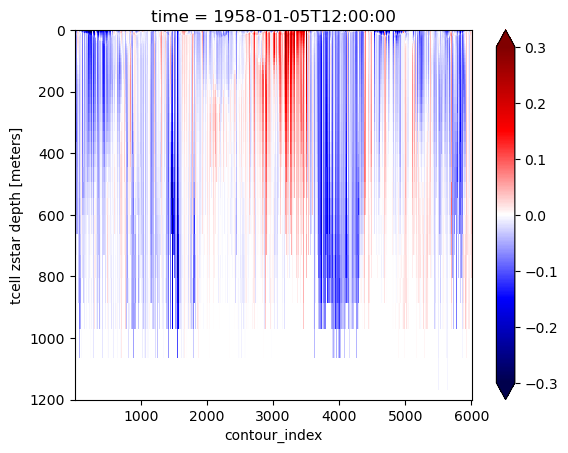

In [97]:
Ualong.isel(time=4).plot(vmin=-0.3,vmax=0.3,cmap='seismic')
plt.ylim(1200,0)

(1200.0, 0.0)

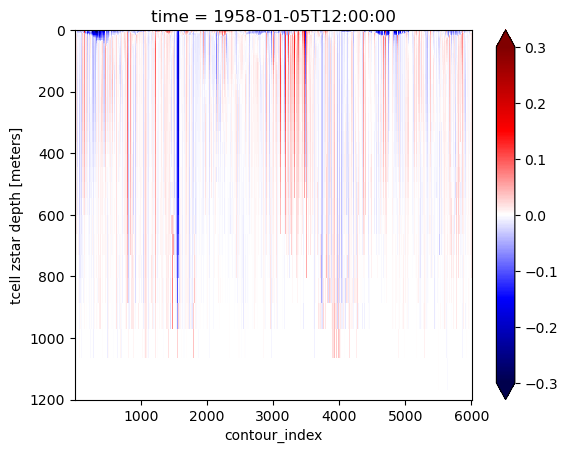

In [98]:
Ucross.isel(time=4).plot(vmin=-0.3,vmax=0.3,cmap='seismic')
plt.ylim(1200,0)

In [102]:
		#Interpolating Thickness to X,Y grid
		gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
		gridx=gridx.isel(time=0,drop=True)         
		dsx = xr.merge([thickness, gridx])
		dsx.coords['xt_ocean'].attrs.update(axis='X')
		dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
		dsx.coords['yt_ocean'].attrs.update(axis='Y')
		dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
		gridx = xgcm.Grid(dsx, periodic=['X'])
		
		
		#y
		gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
		gridy=gridy.isel(time=0,drop=True)         
		dsy = xr.merge([thickness, gridy])
		dsy.coords['xt_ocean'].attrs.update(axis='X')
		dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
		dsy.coords['yt_ocean'].attrs.update(axis='Y')
		dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
		gridy = xgcm.Grid(dsy, periodic=['X'])
		
		# Calculating the slope on the x and y grid
		thickness_xg=gridx.interp(dsx.st_edges_ocean, 'Y').isel(yt_ocean=slice(0,cutout_latind))
		thickness_yg=gridx.interp(dsy.st_edges_ocean, 'X').isel(yu_ocean=slice(0,cutout_latind))

In [103]:
		# Calculating the slope on the x and y grid
		thickness_xg=thickness_xg.rename(yt_ocean='y_ocean',xu_ocean='x_ocean')
		thickness_yg=thickness_yg.rename(yu_ocean='y_ocean',xt_ocean='x_ocean')

In [104]:
		# stack transports into 1d and drop any points not on contour:
		x_thick_1d = thickness_xg.stack(contour_index = ['y_ocean', 'x_ocean'])
		x_thick_1d = x_thick_1d.where(mask_x_numbered_1d>0, drop = True)
		y_thick_1d = thickness_yg.stack(contour_index = ['y_ocean', 'x_ocean'])
		y_thick_1d = y_thick_1d.where(mask_y_numbered_1d>0, drop = True)
		
		# combine all points on contour:
		Uthick = xr.concat((x_thick_1d, y_thick_1d), dim = 'contour_index')
		Uthick = Uthick.sortby(contour_ordering)
		Uthick.coords['contour_index'] = contour_index_array
		Uthick = Uthick.load()

In [107]:
Ualong

<xarray.DataArray (time: 31, st_ocean: 75, contour_index: 6002)>
array([[[ 0.04413945,  0.04774371,  0.05316229, ...,  0.00100349,
          0.03026063,  0.03582298],
        [ 0.03505886,  0.04052982,  0.04497535, ..., -0.00957399,
          0.01926798,  0.02594091],
        [ 0.03075365,  0.03744245,  0.04107553, ..., -0.01540236,
          0.01324711,  0.02118171],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.05629959,  0.06667839,  0.06794807, ...,  0.00919674,
          0.03556998,  0.04922241],
        [ 0.05077096,  0.06122692,  0.0623091 , ...,  0.00316931,
          0.02981723,  0.04362314],
        [ 0.04696604,  0.05798096,  0.05888196, ..., -0.00159018,
          0.02599303,  0.03994989],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.04249784, -0.00240162, -0.00535689, ..., -0.06669644,
         -0.0444302 , -0.03929247],
        [-0.0210211 ,  0.01843918,  0.01773121, ..., -0.04392582,
         -0.02050775, -0.01630417],
        [-0.00935121,  0.02932036,  0.03008985, ..., -0.03114164,
         -0.00697693, -0.00352478],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * st_ocean       (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time           (time) datetime64[ns] 1958-01-01T12:00:00 ... 1958-01-31T1...
  * contour_index  (contour_index) int64 1 2 3 4 5 ... 5998 5999 6000 6001 6002

In [117]:
		import geopy.distance
		distance_along_contour=np.ones(num_points)
		for n in range(num_points-1):
		    coords_1 = (lat_along_contour[n], lon_along_contour[n])
		    coords_2 = (lat_along_contour[n+1], lon_along_contour[n+1])
		    distance_along_contour[n]=geopy.distance.geodesic(coords_1, coords_2).km
            
		coords_1 = (lat_along_contour[-1], lon_along_contour[-1])
		coords_2 = (lat_along_contour[0], lon_along_contour[0])
		distance_along_contour[-1]=geopy.distance.geodesic(coords_1, coords_2).km


In [124]:
         
		        
		# PREVIOUS SAVEDIR TO LOCATE THE FILES save_dir  = '/g/data/x77/wf4500/ASC_project/ASC_speed/monthly/OM2_RYF/'
		save_dir  = '/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z/OM2_RYF_XYgrid/'        
		file_name = 'Antarctic_slope_contour_1km_velocities_'
		
		data_u=xr.DataArray((Ualong),name="u_along_contour",dims=["time","st_ocean","contour_index"])
		data_v=xr.DataArray((Ucross),name="u_cross_contour",dims=["time","st_ocean","contour_index"])
		data_lon=xr.DataArray((lon_along_contour),name="lon_along_contour",dims=["contour_index"])
		data_lat=xr.DataArray((lat_along_contour),name="lat_along_contour",dims=["contour_index"])
		data_dist=xr.DataArray((distance_along_contour),name="distance_along_contour",dims=["contour_index"])


		data_thick=xr.DataArray((Uthick),name="thickness_contour",dims=["st_ocean","contour_index"])
		data_time=xr.DataArray(Ualong.time,name="time",dims=["time"])
		
		data_to_saveuv = xr.merge([data_u,data_v,data_lon,data_lat,data_thick,data_dist])
		data_to_saveuv['contour_index']=Ualong.contour_index
		data_to_saveuv['st_ocean']=np.array(st_ocean)
		data_to_saveuv['time']=Ualong.time
		data_to_saveuv
		data_to_saveuv.to_netcdf(save_dir + file_name + start_time +"_uv.nc")


